# Feature Maps

The goal of this notebook is to be able to see what our neural network is doing at each convolution and pooling layer.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

import itertools

tf.random.set_seed(1)


Loading the Data

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Reshaping the data so it is easier to work with

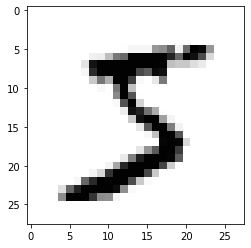

In [3]:
plt.imshow(X_train[0], cmap='Greys')

In [4]:
y_train[0]

5

In [5]:
X_test[0].shape

(28, 28)

In [6]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
#Normalizing the pixels
X_train = X_train / 255
X_test = X_test / 255

In [7]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Now we can begin our function to build our CNN. We do this to be able to run the CNN multiple times with different parameters.

In [8]:
def build_model(conv_layers, pool_layers, epochs, X_train, y_train, X_test, y_test, layer_map):
  cnn_model = build_cnn(conv_layers, pool_layers)
  
    

  # Define a loss function
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

  # Compile the model
  cnn_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

  history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_split=0.3)

  #plot_history(history, epochs)

  #confusionmatrix(model= cnn_model)

  filters(model=cnn_model, X_test= X_test, y_test=y_test, layer_map=layer_map)

  return history

This builds the actual CNN.

In [9]:
def build_cnn(conv_layers, pool_layers):
    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, kernel_size=5,activation='linear',input_shape=(28,28,1),padding='same'))
    model_cnn.add(MaxPooling2D((2, 2), padding='same'))
    model_cnn.add(Dropout(0.4))
    x=64
    for i in range(1, conv_layers):
        if i <= conv_layers-1:        
          model_cnn.add(Conv2D(x, kernel_size=5,activation='linear',padding='same'))
          model_cnn.add(MaxPooling2D((2, 2), padding='same'))
          model_cnn.add(Dropout(0.4))
          x=x*2
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128))
    model_cnn.add(Dense(10, activation='softmax'))

    print(model_cnn.summary())
    return model_cnn

This will plot our accuracy for analysis.

In [10]:
def plot_history(history, epochs):
  epochs = range(epochs)

  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  plt.figure(figsize=(12, 8))
  plt.plot(epochs, train_acc, color='blue', label='Training accuracy')
  plt.plot(epochs, val_acc, color='red', label='Validation accuracy')
  plt.legend()
  plt.grid()

In [11]:
def confusionmatrix(model):

  confusion = confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=-1))

  confusion_norm = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

  classes=[0,1,2,3,4,5,6,7,8,9]

  plt.figure(figsize=(14,14))
  plt.imshow(confusion_norm, interpolation='nearest') 
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes)) 
  plt.xticks(tick_marks, classes, rotation=45) 
  plt.yticks(tick_marks, classes)
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  fmt = '.2f'
  thresh = confusion_norm.max() / 2.
  for i, j in itertools.product(range(confusion_norm.shape[0]), range(confusion_norm.shape[1])):
    plt.text(j, i, format(confusion_norm[i, j], fmt), horizontalalignment="center",
    color="black" if confusion_norm[i, j] > thresh else "white")
  plt.tight_layout()

In [12]:
def filters(model, X_test, y_test, layer_map):
  # redefine model to output right after the first hidden layer
  model = Model(inputs=model.inputs, outputs=model.layers[layer_map].output)
  model.summary()
  # get feature map for first hidden layer
  feature_maps = model.predict(X_test[0].reshape(1,28,28,1))

  height=8
  width=4
  ix = 1
  plt.figure(figsize=(14,14))
  for _ in range(width):
    for _ in range(height):
      ax = plt.subplot(height, width, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(feature_maps[0, :, :, ix-1], cmap='binary')
      ix += 1
  # show the figure
  plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

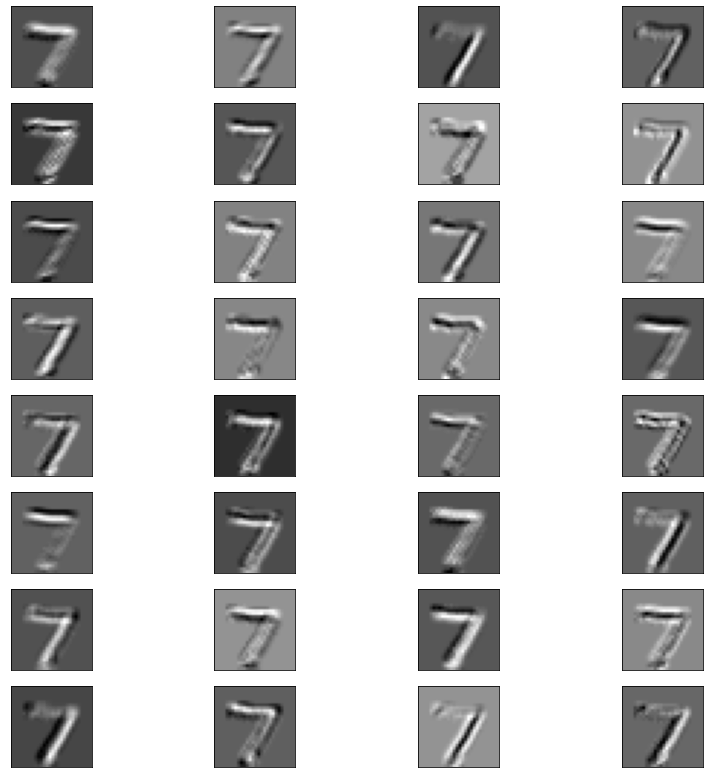

In [13]:
build_model(conv_layers=2, pool_layers=2, epochs=1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, layer_map=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 805,066
Trainable params: 805,066
Non-trainable params: 0
________________________________________________

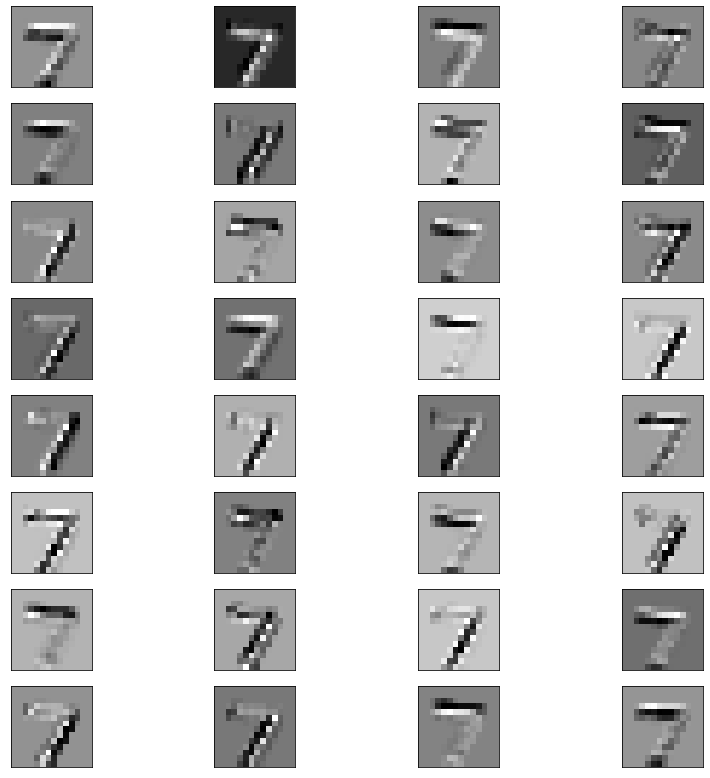

In [14]:
build_model(conv_layers=1, pool_layers=1, epochs=1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, layer_map=1)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 3136)            

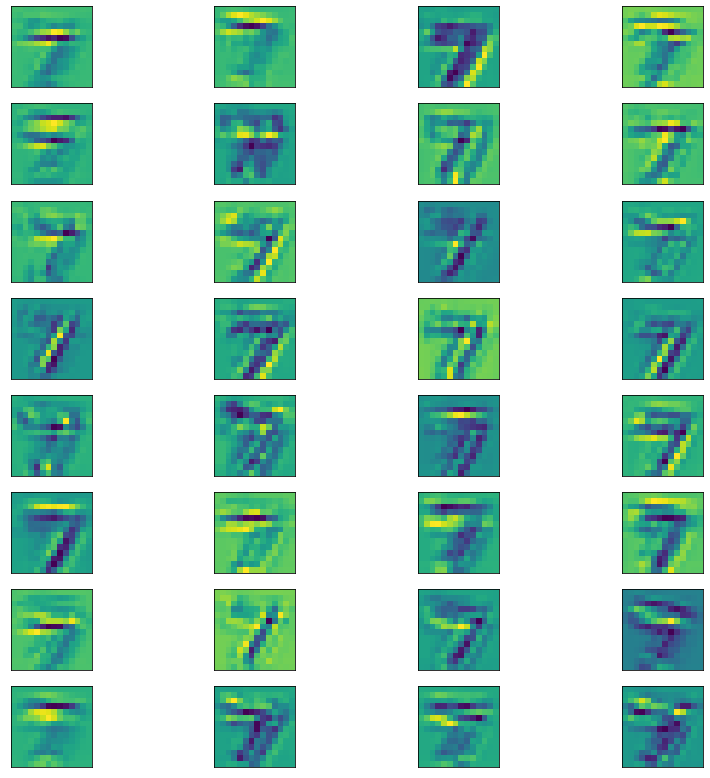

In [77]:
build_model(conv_layers=2, pool_layers=2, epochs=1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, layer_map=3)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 3136)            

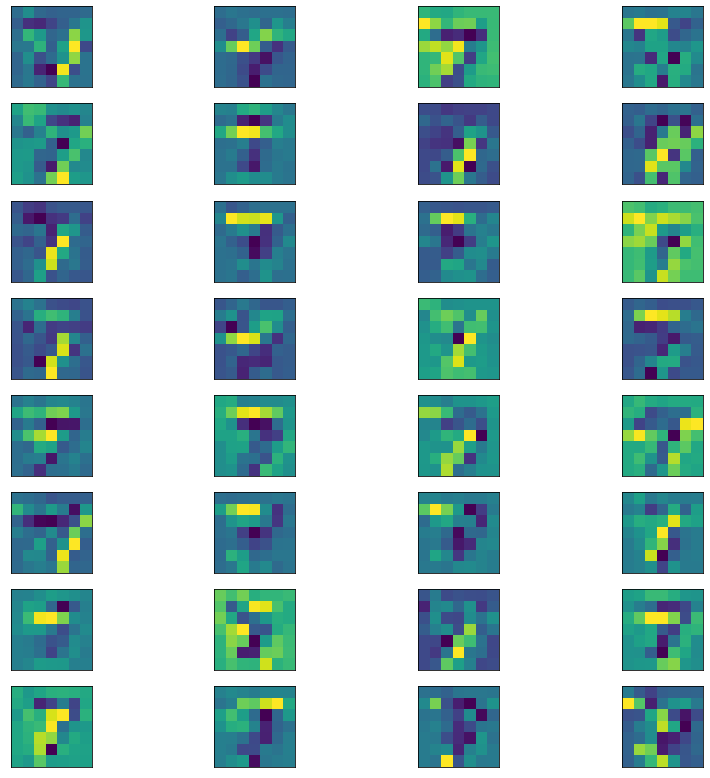

In [78]:
build_model(conv_layers=2, pool_layers=2, epochs=1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, layer_map=4)